# LangGraph Avanzado: Sistemas Multi-Agente Profesionales

## 🎯 Descripcion del Curso

Este notebook se enfoca en tecnicas avanzadas de LangGraph para construir sistemas multi-agente profesionales y robustos. Cubriremos streaming en tiempo real, patrones human-in-the-loop, arquitecturas supervisor y de red, control de flujo avanzado y operacion autonoma.

### ¿Que Aprenderas?

✅ **Streaming y Feedback en Tiempo Real**: Respuestas progresivas como ChatGPT  
✅ **Human-in-the-Loop Patterns**: Intervencion humana inteligente  
✅ **Arquitectura Supervisor**: Coordinacion centralizada de agentes  
✅ **Arquitectura de Red/Swarm**: Colaboracion peer-to-peer  
✅ **Control de Flujo Avanzado**: Comandos y navegacion dinamica  
✅ **Operacion Autonoma**: Sistemas hands-off con auto-recuperacion  

### Requisitos Previos

- Conocimiento basico de LangGraph y LangChain
- Experiencia con Python y programacion asincrona
- Familiaridad con conceptos de sistemas distribuidos


## 🛠️ Configuracion del Entorno

Instalamos todas las dependencias necesarias para trabajar con LangGraph avanzado.


In [1]:
# Instalacion de dependencias
%pip install -q langgraph langchain_openai langchain_core langchain_community langgraph_swarm
%pip install -q langchain-google-genai langgraph-checkpoint-sqlite
%pip install -q matplotlib networkx IPython python-dotenv

print("✅ Todas las dependencias instaladas correctamente")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
✅ Todas las dependencias instaladas correctamente


## 🔑 Configuracion de API Keys

Configuramos las claves de API necesarias. Puedes usar OpenAI o Google Gemini segun tu preferencia.


In [2]:
import os
from dotenv import load_dotenv

# Cargar variables de entorno desde archivo .env (si existe)
load_dotenv()

# Para Google Colab - usa userdata
try:
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
    os.environ['LANGSMITH_API_KEY'] = userdata.get("LANGSMITH_API_KEY")
    os.environ['LANGSMITH_PROJECT'] = 'langraph_avanzado'
    os.environ['LANGSMITH_TRACING'] = "true"
    print("✅ API Key configurada desde Google Colab")
except:
    print("⚠️  Configura tus llaves en las variables de entorno")

os.environ['LANGSMITH_PROJECT'] = 'langraph_avanzado'
os.environ['LANGSMITH_TRACING'] = "true"
# Verificar que tenemos acceso a la API
if os.environ.get("OPENAI_API_KEY"):
    print("🔑 API Key detectada correctamente")
else:
    print("❌ No se detecto API Key. Configurala antes de continuar.")


⚠️  Configura tus llaves en las variables de entorno
🔑 API Key detectada correctamente


## 📦 Importaciones y Configuracion Inicial

Importamos todas las librerias que usaremos y configuramos el modelo principal.


In [3]:
# Importaciones basicas de Python
import json
import time
import sqlite3
import uuid
import random
from typing import Literal, List, Dict, Any, Optional, TypedDict, Annotated
from datetime import datetime

# LangChain y LangGraph imports
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate

# LangGraph core
from langgraph.graph import StateGraph, MessagesState, START, END, add_messages
from langgraph.types import Command, interrupt
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.config import get_stream_writer

# Persistencia y checkpointing
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Visualizacion
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML, Markdown

print("✅ Todas las importaciones completadas")

# Configuracion del modelo principal
try:
    llm = ChatOpenAI(
        model="gpt-4o-mini",
        temperature=0.1,
        max_tokens=1000
    )
    
    # Prueba rapida
    test_response = llm.invoke([HumanMessage(content="Responde con: 'Configuracion exitosa'")])  
    print(f"✅ Modelo configurado: {test_response.content}")
    
except Exception as e:
    print(f"❌ Error de configuracion: {e}")
    print("Verifica tu API key y conexion a internet")

print(f"🤖 Notebook listo para sistemas multi-agente avanzados con LangGraph")


Matplotlib is building the font cache; this may take a moment.


✅ Todas las importaciones completadas
✅ Modelo configurado: Configuracion exitosa.
🤖 Notebook listo para sistemas multi-agente avanzados con LangGraph


---

# 🌊 Streaming y Retroalimentacion en Tiempo Real

## ¿Por que es Importante el Streaming?

El streaming permite que los usuarios vean el progreso de los agentes en tiempo real, similar a como funciona ChatGPT. Esto mejora significativamente la experiencia del usuario y permite debugging avanzado.

### Tipos de Streaming en LangGraph

1. **Stream Updates**: Cambios de estado del grafo
2. **Stream Messages**: Tokens y mensajes conforme se generan  
3. **Stream Personalizado**: Control total con `get_stream_writer()`
4. **Stream Multi-Modal**: Combinacion de multiples modos

### Ventajas del Streaming

✅ **Feedback Inmediato**: Usuario ve progreso en tiempo real  
✅ **Mejor UX**: Experiencia similar a ChatGPT  
✅ **Debugging Avanzado**: Observar cada paso del proceso  
✅ **Transparencia**: Ver que herramientas se ejecutan y cuando  


In [4]:
# Configuracion de persistencia para streaming
print("💾 Configurando sistemas de persistencia...")

# Persistencia en SQLite (permanente)
conexion_sqlite = sqlite3.connect(":memory:", check_same_thread=False)
checkpointer_sqlite = SqliteSaver(conexion_sqlite)
print("✅ SqliteSaver configurado")

# Store para almacenamiento a largo plazo
store_memoria = InMemoryStore()
print("✅ InMemoryStore configurado")

print("🎯 Sistemas de persistencia listos para streaming")


💾 Configurando sistemas de persistencia...
✅ SqliteSaver configurado
✅ InMemoryStore configurado
🎯 Sistemas de persistencia listos para streaming


In [5]:
# Herramientas simples para demostrar streaming
@tool
def procesar_con_progreso(tarea: str) -> str:
    """
    Procesa una tarea mostrando progreso simple.
    
    Args:
        tarea: Descripcion de la tarea a procesar
        
    Returns:
        Resultado del procesamiento
    """
    writer = get_stream_writer()
    
    # Etapas simples
    etapas = ["Iniciando", "Procesando", "Finalizando"]
    
    for i, etapa in enumerate(etapas, 1):
        # Enviar progreso
        writer({
            "tipo": "progreso",
            "etapa": etapa,
            "porcentaje": (i / len(etapas)) * 100
        })
        
        time.sleep(1)  # Simular trabajo
    
    resultado = f"✅ Tarea '{tarea}' completada"
    
    # Enviar resultado final
    writer({
        "tipo": "completado",
        "resultado": resultado
    })
    
    return resultado

@tool
def analizar_simple(datos: str) -> str:
    """
    Analisis simple con progreso.
    
    Args:
        datos: Datos a analizar
        
    Returns:
        Resultado del analisis
    """
    writer = get_stream_writer()
    
    writer({
        "tipo": "inicio",
        "mensaje": f"🚀 Analizando: {datos}"
    })
    
    resultado = llm.stream(f"Analiza los siguientes datos: {datos}, responde en 1 frase corta")

    time.sleep(1)
        
    writer({
        "tipo": "fin",
        "resultado": resultado
    })
    
    return resultado

# Herramientas simplificadas
herramientas_streaming = [procesar_con_progreso, analizar_simple]

print("🛠️ Herramientas de streaming simplificadas:")
for herramienta in herramientas_streaming:
    print(f"  ✅ {herramienta.name}")

🛠️ Herramientas de streaming simplificadas:
  ✅ procesar_con_progreso
  ✅ analizar_simple


## 🧪 Demostracion de Streaming Basico

Vamos a ejecutar ejemplos simples de streaming para ver las actualizaciones en tiempo real.

### Conceptos Clave del Streaming:

1. **get_stream_writer()**: Permite enviar actualizaciones personalizadas durante la ejecucion
2. **stream_mode="updates"**: Muestra cambios de estado del grafo en tiempo real  
3. **Progreso incremental**: Similar a ChatGPT, el usuario ve el proceso paso a paso

### Ventajas del Streaming:

✅ **Feedback inmediato** para el usuario  
✅ **Transparencia** en el proceso de ejecucion  
✅ **Mejor experiencia** similar a aplicaciones modernas  
✅ **Debugging avanzado** para desarrolladores  

In [6]:
# Crear un grafo simple con streaming
def crear_agente_con_streaming(state: MessagesState) -> MessagesState:
    """
    Agente simple que usa herramientas con streaming.
    """
    writer = get_stream_writer()
    
    # Notificar inicio
    writer({
        "tipo": "inicio_agente",
        "mensaje": "🤖 Agente iniciando trabajo"
    })
    
    # Crear agente con herramientas de streaming
    system_prompt = """
    Eres un asistente que puede procesar tareas con streaming.
    Usa las herramientas disponibles cuando sea apropiado.
    no uses herramientas en exceso y termina si llegas a mas de 3 iteraciones
    """
    
    agente_react = create_react_agent(llm, herramientas_streaming, prompt=system_prompt)
    resultado = agente_react.invoke(state)
    
    # Notificar finalizacion
    writer({
        "tipo": "fin_agente",
        "mensaje": "🎉 Agente completo trabajo"
    })
    
    return resultado

# Crear grafo de streaming
builder_streaming = StateGraph(MessagesState)
builder_streaming.add_node("agente_streaming", crear_agente_con_streaming)
builder_streaming.add_edge(START, "agente_streaming")
builder_streaming.add_edge("agente_streaming", END)

grafo_streaming = builder_streaming.compile()

# Demo simplificado de streaming
def demo_streaming_simple():
    """
    Demo simple de streaming que funciona.
    """
    print("🌊 DEMO: Streaming Simple")
    print("="*50)
    
    entrada = {
        "messages": [HumanMessage(content="Procesa un analisis de datos de ventas")]
    }
    
    config = {"configurable": {"thread_id": "streaming_demo"}}
    
    try:
        print("🚀 Ejecutando con streaming:")
        print("-" * 30)
        
        # Ejecutar con streaming mode updates
        for chunk in grafo_streaming.stream(entrada, config=config, stream_mode=["updates", "custom", "messages"]):
            stream_type, content = chunk
            if stream_type == "custom":
                print("Custom:", content['tipo'], content['mensaje'])
            elif stream_type == "messages":
                print("Messages:", content)
            elif stream_type == "updates":
                print("Updates:", content)
        
        print("\n✅ Demo completado")
        
    except Exception as e:
        print(f"❌ Error: {e}")
    
    print("="*50)

# Ejecutar demo
demo_streaming_simple()

🌊 DEMO: Streaming Simple
🚀 Ejecutando con streaming:
------------------------------
Custom: inicio_agente 🤖 Agente iniciando trabajo


/var/folders/x_/8f3zmdqs32x9p1gyw2t52krh0000gn/T/ipykernel_73336/2084860016.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agente_react = create_react_agent(llm, herramientas_streaming, prompt=system_prompt)


Custom: fin_agente 🎉 Agente completo trabajo
Messages: (AIMessage(content='Por favor, proporciona los datos de ventas que deseas analizar.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--019bab4b-75cc-7470-81a8-e1f44439073c', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 157, 'output_tokens': 13, 'total_tokens': 170, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), {'thread_id': 'streaming_demo', 'langgraph_step': 1, 'langgraph_node': 'agente_streaming', 'langgraph_triggers': ('branch:to:agente_streaming',), 'langgraph_path': ('__pregel_pull', 'agente_streaming'), 'langgraph_checkpoint_ns': 'agente_streaming:3067aaa0-a521-8774-0329-a68a04917264', 'LANGSMITH_PROJECT': 'langraph_avanzado', 'LANGSMITH_TRACING': 'true', 'LANGSMITH_ENDPOINT': 

---

# 🤝 Human-in-the-Loop - Intervencion Humana

## ¿Que es Human-in-the-Loop en LangGraph?

Human-in-the-Loop (HITL) permite **pausar la ejecucion del grafo** para que los humanos puedan revisar, editar y aprobar acciones antes de continuar. LangGraph utiliza su sistema de **persistencia y checkpointing** para mantener el estado durante las interrupciones.

### 🔑 Capacidades Clave

- **Estado de Ejecucion Persistente**: Las interrupciones usan la capa de persistencia de LangGraph para pausar indefinidamente hasta que se reanude
- **Checkpointing Automatico**: LangGraph guarda el estado despues de cada paso, permitiendo reanudar desde donde se pauso
- **Puntos de Integracion Flexibles**: La logica HITL puede introducirse en cualquier punto del flujo de trabajo

### 🎯 Tipos de Interrupciones

1. **Interrupciones Dinamicas**: Usar `interrupt()` para pausar desde dentro de un nodo especifico
2. **Interrupciones Estaticas**: Usar `interrupt_before` y `interrupt_after` para pausar en puntos predefinidos

### 📋 Los 4 Patrones Oficiales de HITL

Segun la [documentacion oficial de LangGraph](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/):

1. **🛑 Approve or Reject**: Pausar antes de un paso critico para revisar y aprobar la accion
2. **✏️ Edit Graph State**: Pausar para revisar y editar el estado del grafo
3. **🔍 Review Tool Calls**: Pausar para revisar y editar llamadas de herramientas antes de la ejecucion
4. **✅ Validate Human Input**: Pausar para validar entrada humana antes de proceder


In [7]:
# Configuracion de persistencia para Human-in-the-Loop
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command
from typing import Literal, Dict, Any
import uuid
from datetime import datetime

# Checkpointer necesario para persistencia durante interrupciones
checkpointer = InMemorySaver()

# Estado para HITL (usando MessagesState como base)
class EstadoHITL(MessagesState):
    """
    Estado que incluye informacion para Human-in-the-Loop.
    Basado en MessagesState para compatibilidad con agentes.
    """
    name: Optional[str] = None
    # Salida del LLM para revision
    llm_output: Optional[str] = None
    
    # Resumen generado por LLM para edicion
    llm_generated_email: Optional[str] = None
    
    # Edad para validacion
    age: Optional[int] = None

    rejected_hotels: Optional[List[str]] = None
    accepted_hotel: Optional[str] = None

    booking_email: Optional[str] = None
    
    # Estado de aprobacion
    is_booking_approved: Optional[bool] = None

    flight_number: Optional[str] = None



In [8]:
## 🛑 Patron 1: Approve or Reject

# Implementacion siguiendo la documentacion
def book_hotel(state: EstadoHITL) -> Command[Literal["approved_booking", "rejected_booking"]]:
    """
    Pausa el grafo antes de un paso critico para revisar y aprobar la accion.
    Si la accion es rechazada, puede tomar una ruta alternativa.
    """

    rejected_hotels = state.get("rejected_hotels", [])

    name = state.get("name", "John Doe")

    # Simula un hotel random
    hotel_choices = ["McKittrick Hotel & Spa", "The Plaza Hotel", "The St. Regis New York", "Hyatt Regency New York"]
    hotel_choice = random.choice(hotel_choices)

    # Simular salida del LLM que necesita aprobacion
    llm_output = f"hola {name}, Voy a hacer un booking de un hotel en el {hotel_choice}"
    
    # INTERRUPCION REAL usando interrupt() de LangGraph
    is_approved = interrupt(
        {
            "question": llm_output,
            "type": "book_hotel_aproval"
        }
    )

    # Ruteo basado en la respuesta humana
    if is_approved:
        return Command(goto="approved_booking", update={"accepted_hotel": hotel_choice})
    else:
        return Command(goto="rejected_booking", update={"rejected_hotels": rejected_hotels + [hotel_choice]})

def aproved_booking(state: EstadoHITL) -> Command[Literal["send_email"]]:
    """Nodo que se ejecuta cuando la accion es aprobada."""
    print("booking aprobado, pasando a send_email")
    return Command(
        goto="send_email",
        update={"is_booking_approved": True, 
                "messages": [AIMessage(content="✅ Booking aprobado y enviado correctamente.")]
                }
                )

def rejected_booking(state: EstadoHITL) -> Command[Literal["book_hotel"]]:
    """Nodo que se ejecuta cuando la accion es rechazada."""
    print("booking rechazado, volviendo a book_hotel")
    return Command(
        goto="book_hotel", 
        update={"is_booking_approved": False, 
                "messages": [AIMessage(content="❌ Booking rechazado. Tomando accion alternativa.")]
                }
                )



In [9]:
## ✏️ Patron 2: Edit Graph State

# Implementacion siguiendo la documentacion oficial de LangGraph
def send_email(state: EstadoHITL) -> Command[Literal["book_plane"]]:
    """
    Pausa el grafo para revisar y editar el estado.
    Util para corregir errores o actualizar el estado con informacion adicional.
    """
    print("Inside send email")
    # Generar resumen inicial del LLM
    llm_generated_email = "Hola como estas, tu reserva esta lista para el 10 de diciembre"
    
    # INTERRUPCION REAL para edicion de estado
    result = interrupt(
        # Informacion de interrupcion para mostrar al cliente
        # Puede ser cualquier valor serializable en JSON
        {
            "task": "Revisa el email y realiza las ediciones necesarias.",
            "llm_generated_email": llm_generated_email,
            "instructions": "Edita el texto si es necesario para mejorar la precision o claridad.",
            "type": "send_email_aproval"
        }
    )
    print("email editado:", result["edited_text"])
    print("pasando a book_plane")
    
    # Actualizar el estado con el texto editado
    return Command(goto="book_plane",
                update={"llm_generated_email": result["edited_text"],
                        "messages": [AIMessage(content=f"✏️ Email editado: {result['edited_text']}")]})

In [10]:
## 🔍 Patron 3: Review Tool Calls

def book_plane(state: EstadoHITL) -> Command[Literal["check_age"]]:
    """
    Herramienta sensible que requiere revision/aprobacion humana.
    Reserva un hotel usando interrupt() para pausar antes de ejecutar.
    """
    print("Inside book plane")

    flight_number = random.choice(["BA123", "BA456", "BA789"])
    
    # INTERRUPCION REAL antes de ejecutar la herramienta sensible
    response = interrupt(  
        {
            "question": f"Intentando llamar `book_plane` con argumentos {{'flight_number': {flight_number}}}. Por favor, aprueba o sugiere ediciones.",
            "type": "book_plane_aproval"
        }
    )
    
    # Procesar respuesta humana
    if response["type"] == "accept":
        print("vuelo aprobado, pasando a check_age")
        # Continuar con los argumentos originales
        pass
    elif response["type"] == "edit":
        print(f"vuelo editado por nuevo vuelo {response['flight_number']}, pasando a check_age")
        # Usar argumentos editados por el humano
        flight_number = response["flight_number"]
    else:
        raise ValueError(f"Tipo de respuesta desconocido: {response['type']}")
    
    return Command(goto="check_age", update={"flight_number": flight_number})


In [11]:
## ✅ Patron 4: Validate Human Input
from langgraph.graph import END
# Implementacion siguiendo la documentacion oficial de LangGraph
def check_age(state: EstadoHITL) -> Command[Literal[END]]:
    """
    Nodo humano con validacion.
    Si necesitas validar la entrada humana dentro del grafo (en lugar de en el lado del cliente),
    puedes usar multiples llamadas interrupt() dentro de un solo nodo.
    """
    print("Inside check age")
    question = "¿Cual es tu edad?"

    while True:
        # INTERRUPCION REAL para solicitar entrada
        answer = interrupt(
            {
                "question": question,
                "type": "check_age_aproval"
            }
        )

        # Validar respuesta, si no es valida pedir entrada nuevamente
        if not isinstance(answer, int) or answer < 0:
            question = f"'{answer}' no es una edad valida. ¿Cual es tu edad?"
            answer = None
            continue
        else:
            # Si la respuesta es valida, podemos proceder
            break

    print(f"El humano en el loop tiene {answer} anos.")
    return Command(goto= END,
                   update={"age": answer,
                           "messages": [AIMessage(content=f"✅ Edad validada: {answer} anos")]
                             })


In [40]:
## 🏗️ Ejemplo Completo: Grafo con Human-in-the-Loop

# Crear un grafo completo que demuestre los patrones HITL
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

def create_hitl_workflow():
    """
    Crea un workflow completo que demuestra todos los patrones HITL.
    """
    # Crear el grafo
    workflow = StateGraph(EstadoHITL)
    
    # Agregar nodos para cada patron
    workflow.add_node("book_hotel", book_hotel)
    workflow.add_node("approved_booking", aproved_booking)
    workflow.add_node("rejected_booking", rejected_booking)
    workflow.add_node("send_email", send_email)
    workflow.add_node("book_plane", book_plane)
    workflow.add_node("check_age", check_age)
    
    # Agregar bordes
    workflow.add_edge(START, "book_hotel")
    
    # Compilar con checkpointer para persistencia
    return workflow.compile(checkpointer=checkpointer)

# Crear el grafo
hitl_graph = create_hitl_workflow()

print("🏗️ Grafo HITL completo creado")
print("✅ Incluye todos los 4 patrones de Human-in-the-Loop")

🏗️ Grafo HITL completo creado
✅ Incluye todos los 4 patrones de Human-in-the-Loop


In [41]:
# Super Simple HITL with input()
def run_hitl():
    state = {"name": "jose"}
    config = {"configurable": {"thread_id": "simple"}}
    result = hitl_graph.invoke(state, config=config)

    while True:
        
        interrupt = result.get("__interrupt__")
        
        if interrupt:
            data = interrupt[0].value if isinstance(interrupt, list) else interrupt.value
            itype = data.get("type")
            question = data.get("question", "")
            
            print(f"\n🛑 {itype}")
            print(f"❓ {question}")
            
            if itype == "book_hotel_aproval":
                resp = input("Type 'y' to approve, 'n' to reject: ").lower()
                if resp == 'e':
                    print("Exiting...")
                    break
                print(resp)
                response = resp == 'y'
                
            elif itype == "send_email_aproval":
                current = data.get('llm_generated_email', '')
                print(f"Current text: {current}")
                resp = input("Enter new text (or press Enter to keep): ").strip()
                if resp == 'e':
                    print("Exiting...")
                    break
                response = {"edited_text": resp if resp else current}
                
            elif itype == "book_plane_aproval":
                resp = input("Type 'accept' or 'edit': ").lower()
                if resp == 'e':
                    print("Exiting...")
                    break
                if resp == 'edit':
                    flight = input("Enter flight number: ").strip()
                    response = {"type": "edit", "flight_number": flight}
                else:
                    response = {"type": "accept"}
                    
            elif itype == "check_age_aproval":
                resp = input("Enter age: ")
                if resp == 'e':
                    print("Exiting...")
                    break
                else:
                    response = int(resp)
                
            result = hitl_graph.invoke(Command(resume=response), config=config)
            
        else:
            print("✅ Done:", result)
            break
    
    return result

run_hitl()


🛑 book_hotel_aproval
❓ hola jose, Voy a hacer un booking de un hotel en el The Plaza Hotel
n
booking rechazado, volviendo a book_hotel

🛑 book_hotel_aproval
❓ hola jose, Voy a hacer un booking de un hotel en el The Plaza Hotel
y
booking aprobado, pasando a send_email
Inside send email

🛑 send_email_aproval
❓ 
Current text: Hola como estas, tu reserva esta lista para el 10 de diciembre
Inside send email
email editado: nola mi amigo como estas
pasando a book_plane
Inside book plane

🛑 book_plane_aproval
❓ Intentando llamar `book_plane` con argumentos {'flight_number': BA456}. Por favor, aprueba o sugiere ediciones.
Inside book plane
vuelo editado por nuevo vuelo BA457, pasando a check_age
Inside check age

🛑 check_age_aproval
❓ ¿Cual es tu edad?
Inside check age
El humano en el loop tiene 40 anos.
✅ Done: {'messages': [AIMessage(content='❌ Booking rechazado. Tomando accion alternativa.', additional_kwargs={}, response_metadata={}, id='061ddc3e-c301-4905-9f80-a2da92f05181'), AIMessage(co

{'messages': [AIMessage(content='❌ Booking rechazado. Tomando accion alternativa.', additional_kwargs={}, response_metadata={}, id='061ddc3e-c301-4905-9f80-a2da92f05181'),
  AIMessage(content='✅ Booking aprobado y enviado correctamente.', additional_kwargs={}, response_metadata={}, id='814f3052-584e-4460-8ab8-92546594c84a'),
  AIMessage(content='✏️ Email editado: nola mi amigo como estas', additional_kwargs={}, response_metadata={}, id='c6a8917b-92bc-43d8-8637-b7900334d099'),
  AIMessage(content='✅ Edad validada: 40 anos', additional_kwargs={}, response_metadata={}, id='47915ad5-0029-41d0-86fc-f02526b17397')],
 'name': 'jose',
 'llm_generated_email': 'nola mi amigo como estas',
 'age': 40,
 'rejected_hotels': ['The St. Regis New York'],
 'accepted_hotel': 'Hyatt Regency New York',
 'is_booking_approved': True,
 'flight_number': 'BA457'}

---

# 👥 Arquitectura Supervisor - Coordinacion Centralizada

## ¿Que es la Arquitectura Supervisor?

La arquitectura supervisor es un patron donde un agente central (supervisor) coordina y dirige el trabajo de multiples agentes especializados. Es como un director de orquesta que coordina diferentes musicos.

### Caracteristicas Clave

- **Coordinacion Centralizada**: Un supervisor toma decisiones sobre que agente debe actuar
- **Especializacion**: Cada agente se enfoca en tareas especificas
- **Flujo Controlado**: El supervisor determina el orden y la logica de ejecucion
- **Estado Compartido**: Todos los agentes comparten informacion a traves del estado

### Ventajas de la Arquitectura Supervisor

✅ **Control Claro**: Flujo de ejecucion predecible  
✅ **Especializacion**: Agentes optimizados para tareas especificas  
✅ **Escalabilidad**: Facil anadir nuevos agentes especializados  
✅ **Debugging**: Facil seguir el flujo de decision  
✅ **Reutilizacion**: Agentes pueden ser reutilizados en diferentes contextos  

### Desventajas

❌ **Cuello de Botella**: El supervisor puede limitar el paralelismo  
❌ **Complejidad Central**: Toda la logica de decision esta en un lugar  
❌ **Punto de Fallo**: Si el supervisor falla, todo el sistema se detiene  


In [12]:
# Estado extendido para sistemas multi-agente
class EstadoMultiAgente(MessagesState):
    """
    Estado para sistemas multi-agente con informacion de coordinacion.
    """
    # Agente actualmente activo
    agente_actual: Optional[str]
    
    # Historial de agentes que han trabajado
    historial_agentes: List[str]
    
    # Resultados de cada agente especializado
    resultados_agentes: Dict[str, Any]
    
    # Proxima tarea a realizar
    proxima_tarea: Optional[str]
    
    # Plan de trabajo general
    plan_trabajo: List[str]
    
    # Metadatos de coordinacion
    coordinacion: Dict[str, Any]

print("👥 Estado Multi-Agente configurado")
print("✅ Listo para implementar arquitectura supervisor")


👥 Estado Multi-Agente configurado
✅ Listo para implementar arquitectura supervisor


In [13]:
# El Supervisor: Coordinador Inteligente
def supervisor(state: EstadoMultiAgente) -> Command:
    """
    Supervisor que coordina el trabajo de los agentes especializados.
    
    El supervisor analiza:
    1. La solicitud del usuario
    2. El trabajo ya completado por otros agentes
    3. Lo que falta por hacer
    4. Decide que agente debe actuar a continuacion
    """
    
    # Obtener informacion del estado actual
    historial_agentes = state.get("historial_agentes", [])
    resultados_agentes = state.get("resultados_agentes", {})
    ultimo_mensaje = state["messages"][-1].content if state["messages"] else ""
    
    # Construir contexto para la decision
    contexto_decision = f"""
    INFORMACION ACTUAL:
    - Solicitud del usuario: {ultimo_mensaje}
    - Agentes que han trabajado: {historial_agentes}
    - Resultados disponibles: {list(resultados_agentes.keys())}
    
    AGENTES DISPONIBLES:
    - investigador: Recolecta informacion y datos relevantes
    - analista: Analiza datos y encuentra patrones
    - escritor: Redacta contenido claro y organizado  
    - revisor: Revisa calidad y coherencia
    
    REGLAS DE COORDINACION:
    1. Si no hay investigacion, empezar con 'investigador'
    2. Si hay investigacion pero no analisis, usar 'analista'  
    3. Si hay analisis pero no redaccion, usar 'escritor'
    4. Si hay redaccion pero no revision, usar 'revisor'
    5. Si todo esta completo, usar 'END'
    6. Si se necesita mas trabajo en cualquier area, reasignar, pero nunca mas de 2 veces por agente
    
    ESTADO ACTUAL DE RESULTADOS:
    """
    
    # Anadir resumen de resultados existentes
    for agente, resultado in resultados_agentes.items():
        estado_agente = resultado.get("estado", "desconocido")
        tipo_trabajo = resultado.get("tipo", "desconocido")
        contexto_decision += f"\n- {agente}: {tipo_trabajo} ({estado_agente})"
    
    system_prompt = f"""
    Eres un supervisor experto que coordina un equipo de agentes especializados.
    
    {contexto_decision}
    
    Analiza la situacion y decide cual debe ser el PROXIMO PASO:
    
    DECISION REQUERIDA:
    Responde UNICAMENTE con el nombre del agente que debe actuar a continuacion:
    - 'investigador' 
    - 'analista'
    - 'escritor' 
    - 'revisor'
    - 'END' (si el trabajo esta completo)
    
    JUSTIFICA tu decision brevemente explicando por que ese agente es el indicado.
    MANDATORIO: NUNCA PASES MAS DE 8 TURNOS, AL FINAL DEBE SER END
    """
    
    # Obtener decision del supervisor
    messages = [SystemMessage(content=system_prompt)] + state["messages"]
    respuesta_supervisor = llm.invoke(messages)
    decision_texto = respuesta_supervisor.content.lower()
    
    # Extraer la decision del texto
    agente_siguiente = "END"  # Por defecto
    
    if "investigador" in decision_texto:
        agente_siguiente = "investigador"
    elif "analista" in decision_texto:
        agente_siguiente = "analista"  
    elif "escritor" in decision_texto:
        agente_siguiente = "escritor"
    elif "revisor" in decision_texto:
        agente_siguiente = "revisor"
    elif "end" in decision_texto or "fin" in decision_texto:
        agente_siguiente = END
    
    # Registrar la decision del supervisor
    coordinacion_actual = state.get("coordinacion", {})
    coordinacion_actual["ultima_decision"] = {
        "timestamp": datetime.now().isoformat(),
        "agente_elegido": agente_siguiente,
        "justificacion": respuesta_supervisor.content,
        "contexto": {
            "agentes_trabajados": historial_agentes,
            "resultados_disponibles": list(resultados_agentes.keys())
        }
    }
    
    # Crear mensaje informativo del supervisor
    mensaje_supervisor = AIMessage(
        content=f"🎭 SUPERVISOR: {respuesta_supervisor.content}\n\n" +
               f"➡️ Siguiente agente: {agente_siguiente}"
    )
    
    # Actualizar plan de trabajo si es necesario
    plan_actual = state.get("plan_trabajo", [])
    if not plan_actual:
        # Crear plan inicial basado en la solicitud
        plan_actual = ["investigar", "analizar", "redactar", "revisar"]
    
    return Command(
        goto=agente_siguiente,
        update={
            "messages": [mensaje_supervisor],
            "agente_actual": "supervisor",
            "proxima_tarea": agente_siguiente,
            "coordinacion": coordinacion_actual,
            "plan_trabajo": plan_actual
        }
    )

print("🎭 Supervisor creado con inteligencia de coordinacion")
print("✅ Funcionalidades del supervisor:")
print("  - Analisis de contexto actual")
print("  - Decision basada en reglas y estado")
print("  - Tracking de progreso del equipo")
print("  - Justificacion de decisiones")
print("  - Gestion de plan de trabajo")


🎭 Supervisor creado con inteligencia de coordinacion
✅ Funcionalidades del supervisor:
  - Analisis de contexto actual
  - Decision basada en reglas y estado
  - Tracking de progreso del equipo
  - Justificacion de decisiones
  - Gestion de plan de trabajo


In [14]:
# Agentes Especializados
def agente_investigador(state: EstadoMultiAgente) -> Command[Literal["supervisor"]]:
    """
    Agente especializado en investigacion y recoleccion de informacion.
    """
    sistema_investigador = """
    Eres un investigador experto especializado en:
    - Recoleccion de informacion relevante
    - Busqueda de datos y fuentes confiables  
    - Identificacion de hechos clave
    - Organizacion de hallazgos
    
    Tu trabajo es fundamental para que otros agentes puedan realizar analisis precisos.
    Siempre proporciona fuentes y contexto de la informacion encontrada.
    """
    
    # Procesar la solicitud de investigacion
    messages = [SystemMessage(content=sistema_investigador)] + state["messages"]
    respuesta = llm.invoke(messages)
    
    # Registrar el trabajo realizado
    resultados_anteriores = state.get("resultados_agentes", {})
    resultados_anteriores["investigador"] = {
        "timestamp": datetime.now().isoformat(),
        "contenido": respuesta.content,
        "tipo": "investigacion",
        "estado": "completado"
    }
    
    # Actualizar historial de agentes
    historial = state.get("historial_agentes", [])
    if "investigador" not in historial:
        historial.append("investigador")
    
    # Retornar control al supervisor usando Command
    return Command(
        goto="supervisor",
        update={
            "messages": [respuesta],
            "agente_actual": "investigador", 
            "historial_agentes": historial,
            "resultados_agentes": resultados_anteriores
        }
    )

def agente_analista(state: EstadoMultiAgente) -> Command[Literal["supervisor"]]:
    """
    Agente especializado en analisis de datos y patrones.
    """
    sistema_analista = """
    Eres un analista de datos experto especializado en:
    - Analisis estadistico y tendencias
    - Identificacion de patrones y correlaciones
    - Interpretacion de datos complejos
    - Generacion de insights accionables
    
    Trabajas con la informacion proporcionada por el investigador para extraer
    conclusiones valiosas y recomendaciones basadas en datos.
    """
    
    # Obtener resultados del investigador si estan disponibles
    resultados_investigador = state.get("resultados_agentes", {}).get("investigador", {})
    contexto_adicional = ""
    
    if resultados_investigador:
        contexto_adicional = f"\n\nInformacion del investigador:\n{resultados_investigador.get('contenido', '')}"
    
    messages = [SystemMessage(content=sistema_analista + contexto_adicional)] + state["messages"]
    respuesta = llm.invoke(messages)
    
    # Registrar resultados
    resultados_anteriores = state.get("resultados_agentes", {})
    resultados_anteriores["analista"] = {
        "timestamp": datetime.now().isoformat(),
        "contenido": respuesta.content,
        "tipo": "analisis",
        "estado": "completado",
        "basado_en": ["investigador"] if resultados_investigador else []
    }
    
    # Actualizar historial
    historial = state.get("historial_agentes", [])
    if "analista" not in historial:
        historial.append("analista")
    
    return Command(
        goto="supervisor",
        update={
            "messages": [respuesta],
            "agente_actual": "analista",
            "historial_agentes": historial, 
            "resultados_agentes": resultados_anteriores
        }
    )

def agente_escritor(state: EstadoMultiAgente) -> Command[Literal["supervisor"]]:
    """
    Agente especializado en redaccion y comunicacion.
    """
    sistema_escritor = """
    Eres un escritor profesional especializado en:
    - Redaccion clara y persuasiva
    - Estructura y organizacion de contenido
    - Adaptacion del tono segun la audiencia
    - Sintesis de informacion compleja
    
    Tu mision es transformar los datos e insights de otros agentes en 
    comunicacion efectiva y comprensible para el usuario final.
    """
    
    # Recopilar informacion de agentes anteriores
    resultados_agentes = state.get("resultados_agentes", {})
    contexto_completo = ""
    
    for agente, resultado in resultados_agentes.items():
        if agente != "escritor":
            contexto_completo += f"\n\n=== Informacion de {agente.title()} ===\n{resultado.get('contenido', '')}"
    
    messages = [SystemMessage(content=sistema_escritor + contexto_completo)] + state["messages"]
    respuesta = llm.invoke(messages)
    
    # Registrar resultados
    resultados_anteriores = state.get("resultados_agentes", {})
    resultados_anteriores["escritor"] = {
        "timestamp": datetime.now().isoformat(),
        "contenido": respuesta.content,
        "tipo": "redaccion",
        "estado": "completado",
        "basado_en": list(resultados_agentes.keys())
    }
    
    # Actualizar historial
    historial = state.get("historial_agentes", [])
    if "escritor" not in historial:
        historial.append("escritor")
    
    return Command(
        goto="supervisor",
        update={
            "messages": [respuesta],
            "agente_actual": "escritor",
            "historial_agentes": historial,
            "resultados_agentes": resultados_anteriores
        }
    )

def agente_revisor(state: EstadoMultiAgente) -> Command[Literal["supervisor"]]:
    """
    Agente especializado en revision y control de calidad.
    """
    sistema_revisor = """
    Eres un revisor experto especializado en:
    - Control de calidad del contenido
    - Verificacion de precision y coherencia
    - Mejora de claridad y estructura
    - Validacion de completitud
    
    Tu rol es asegurar que el trabajo final cumple con los estandares
    mas altos de calidad antes de ser entregado al usuario.
    """
    
    # Obtener el trabajo del escritor para revisar
    resultado_escritor = state.get("resultados_agentes", {}).get("escritor", {})
    
    if resultado_escritor:
        contexto_revision = f"\n\nContenido a revisar:\n{resultado_escritor.get('contenido', '')}"
    else:
        contexto_revision = "\n\nNo hay contenido del escritor para revisar aun."
    
    messages = [SystemMessage(content=sistema_revisor + contexto_revision)] + state["messages"]
    respuesta = llm.invoke(messages)
    
    # Registrar resultados
    resultados_anteriores = state.get("resultados_agentes", {})
    resultados_anteriores["revisor"] = {
        "timestamp": datetime.now().isoformat(),
        "contenido": respuesta.content,
        "tipo": "revision",
        "estado": "completado",
        "basado_en": ["escritor"] if resultado_escritor else []
    }
    
    # Actualizar historial
    historial = state.get("historial_agentes", [])
    if "revisor" not in historial:
        historial.append("revisor")
    
    return Command(
        goto="supervisor",
        update={
            "messages": [respuesta],
            "agente_actual": "revisor",
            "historial_agentes": historial,
            "resultados_agentes": resultados_anteriores
        }
    )

print("🎯 Agentes especializados creados:")
print("  👨‍🔬 Investigador: Recoleccion de informacion")
print("  📊 Analista: Analisis de datos y patrones") 
print("  ✍️ Escritor: Redaccion y comunicacion")
print("  🔍 Revisor: Control de calidad")
print("\n✅ Todos los agentes usan Command para coordinacion")


🎯 Agentes especializados creados:
  👨‍🔬 Investigador: Recoleccion de informacion
  📊 Analista: Analisis de datos y patrones
  ✍️ Escritor: Redaccion y comunicacion
  🔍 Revisor: Control de calidad

✅ Todos los agentes usan Command para coordinacion


🏗️ Sistema Multi-Agente Supervisor creado

📊 Arquitectura implementada:
   START → supervisor → {investigador|analista|escritor|revisor|END}
   Cada agente → supervisor (decision siguiente)

✅ Caracteristicas del sistema:
  - 4 agentes especializados
  - 1 supervisor coordinador
  - Estado compartido entre todos
  - Persistencia con SQLite
  - Flujo dinamico basado en contexto


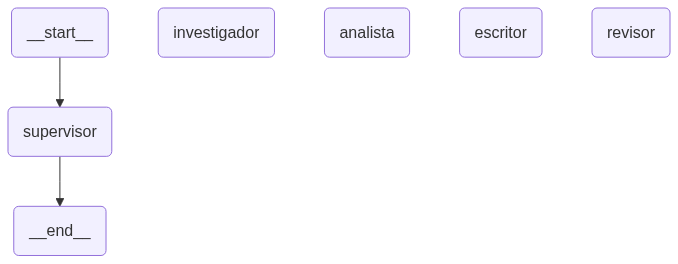

In [45]:
# Construccion del sistema multi-agente supervisor
from IPython.display import Image
def crear_sistema_supervisor():
    """
    Crea el sistema multi-agente completo con arquitectura supervisor.
    """
    
    # Crear el grafo con estado multi-agente
    builder = StateGraph(EstadoMultiAgente)
    
    # Anadir el supervisor como nodo central
    builder.add_node("supervisor", supervisor)
    
    # Anadir todos los agentes especializados
    builder.add_node("investigador", agente_investigador)
    builder.add_node("analista", agente_analista)
    builder.add_node("escritor", agente_escritor)
    builder.add_node("revisor", agente_revisor)
    
    # Definir el flujo de control
    # Todo comienza con el supervisor
    builder.add_edge(START, "supervisor")
    
    # Los agentes especializados retornan al supervisor automaticamente
    # (esto se maneja por los Commands que retornan los agentes)
    
    return builder.compile(checkpointer=checkpointer_sqlite)

# Crear el sistema
sistema_supervisor = crear_sistema_supervisor()

print("🏗️ Sistema Multi-Agente Supervisor creado")
print("\n📊 Arquitectura implementada:")
print("   START → supervisor → {investigador|analista|escritor|revisor|END}")
print("   Cada agente → supervisor (decision siguiente)")
print("\n✅ Caracteristicas del sistema:")
print("  - 4 agentes especializados")
print("  - 1 supervisor coordinador")
print("  - Estado compartido entre todos")
print("  - Persistencia con SQLite")
print("  - Flujo dinamico basado en contexto")
Image(sistema_supervisor.get_graph().draw_mermaid_png())


In [46]:
# Funcion para probar el sistema supervisor
def probar_sistema_supervisor(solicitud: str, thread_id: str = "supervisor_demo", mostrar_detalles: bool = True):
    """
    Prueba el sistema supervisor con una solicitud especifica.
    """
    print(f"\n🧪 PRUEBA DEL SISTEMA SUPERVISOR")
    print("="*60)
    print(f"👤 Solicitud: {solicitud}")
    print(f"🧵 Thread ID: {thread_id}")
    print("="*60)
    
    # Preparar entrada
    entrada = {
        "messages": [HumanMessage(content=solicitud)],
        "agente_actual": None,
        "historial_agentes": [],
        "resultados_agentes": {},
        "proxima_tarea": None,
        "plan_trabajo": [],
        "coordinacion": {}
    }
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # Contadores para tracking
    paso = 0
    agentes_trabajados = set()
    
    try:
        # Ejecutar con streaming para ver el proceso
        for chunk in sistema_supervisor.stream(entrada, config=config, stream_mode="updates"):
            paso += 1
            
            for nodo, datos in chunk.items():
                agentes_trabajados.add(nodo)
                
                print(f"\n📍 PASO {paso}: Nodo '{nodo}' activo")
                
                if mostrar_detalles and "messages" in datos and datos["messages"]:
                    mensaje = datos["messages"][-1]
                    contenido = mensaje.content
                    
                    # Mostrar contenido segun el tipo de nodo
                    if nodo == "supervisor":
                        print(f"🎭 {contenido}")
                    elif nodo == "investigador":
                        print(f"👨‍🔬 INVESTIGADOR: {contenido[:200]}{'...' if len(contenido) > 200 else ''}")
                    elif nodo == "analista":
                        print(f"📊 ANALISTA: {contenido[:200]}{'...' if len(contenido) > 200 else ''}")
                    elif nodo == "escritor":
                        print(f"✍️ ESCRITOR: {contenido[:200]}{'...' if len(contenido) > 200 else ''}")
                    elif nodo == "revisor":
                        print(f"🔍 REVISOR: {contenido[:200]}{'...' if len(contenido) > 200 else ''}")
                
                # Mostrar informacion de coordinacion
                if "coordinacion" in datos and datos["coordinacion"]:
                    coordinacion = datos["coordinacion"]
                    if "ultima_decision" in coordinacion:
                        decision = coordinacion["ultima_decision"]
                        print(f"   ➡️ Proximo: {decision.get('agente_elegido', 'N/A')}")
                
                print("-" * 40)
        
        # Mostrar resumen final
        estado_final = sistema_supervisor.get_state(config)
        
        print(f"\n🎯 RESUMEN FINAL")
        print(f"📊 Total de pasos: {paso}")
        print(f"👥 Agentes que trabajaron: {', '.join(sorted(agentes_trabajados))}")
        
        if estado_final.values.get("resultados_agentes"):
            resultados = estado_final.values["resultados_agentes"]
            print(f"📋 Resultados generados por: {', '.join(resultados.keys())}")
            for agente, resultado in resultados.items():
                print(f"🔍 {agente}: {resultado}")
        
        return estado_final.values
        
    except Exception as e:
        print(f"❌ Error durante la ejecucion: {e}")
        return None

# Prueba del sistema supervisor
resultado_supervisor = probar_sistema_supervisor(
    "Necesito un analisis completo sobre las tendencias del mercado de inteligencia artificial en 2024",
    "demo_supervisor_ia"
)




🧪 PRUEBA DEL SISTEMA SUPERVISOR
👤 Solicitud: Necesito un analisis completo sobre las tendencias del mercado de inteligencia artificial en 2024
🧵 Thread ID: demo_supervisor_ia

📍 PASO 1: Nodo 'supervisor' activo
🎭 🎭 SUPERVISOR: 🎭 SUPERVISOR: investigador

La solicitud del usuario requiere un analisis completo sobre las tendencias del mercado de inteligencia artificial en 2024, pero actualmente no hay informacion ni datos disponibles. Por lo tanto, el primer paso es que el 'investigador' recolecte informacion y datos relevantes sobre el tema antes de proceder a cualquier analisis.

➡️ Siguiente agente: investigador

➡️ Siguiente agente: investigador
   ➡️ Proximo: investigador
----------------------------------------

📍 PASO 2: Nodo 'investigador' activo
👨‍🔬 INVESTIGADOR: Para realizar un analisis completo sobre las tendencias del mercado de inteligencia artificial (IA) en 2024, es fundamental considerar varios aspectos clave, incluyendo el crecimiento del mercado, las...
--------------

---

# 🕸️ Arquitectura de Red/Swarm - Colaboracion Peer-to-Peer

## ¿Que es la Arquitectura de Red?

A diferencia de la arquitectura supervisor, en el patron de red (o swarm) los agentes pueden comunicarse directamente entre si sin necesidad de un coordinador central. Es como una red de colegas que colaboran de manera peer-to-peer.

### Caracteristicas Clave de la Red Colaborativa

- **Comunicacion Directa**: Los agentes se comunican entre si directamente
- **Transferencia de Control**: Los agentes pueden pasarse el control usando "handoffs"
- **Autonomia**: Cada agente decide cuando y a quien transferir el trabajo
- **Flexibilidad**: Flujo de trabajo mas organico y adaptativo
- **Especializacion Dinamica**: Los agentes pueden asumir diferentes roles segun el contexto

### Ventajas de la Arquitectura de Red

✅ **Flexibilidad**: Flujo de trabajo adaptativo y organico  
✅ **Resiliencia**: No hay un punto unico de fallo  
✅ **Paralelismo**: Los agentes pueden trabajar simultaneamente  
✅ **Especializacion Dinamica**: Los roles pueden cambiar segun la necesidad  
✅ **Escalabilidad**: Facil anadir nuevos nodos a la red  

### Desventajas

❌ **Complejidad**: Mas dificil de predecir y debuggear  
❌ **Coordinacion**: Puede haber conflictos o duplicacion de trabajo  
❌ **Overhead**: Mas comunicacion entre agentes  


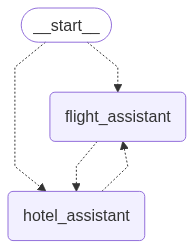

In [19]:
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool
from IPython.display import Image

@tool
def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."

@tool
def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f"Successfully booked a flight from {from_airport} to {to_airport}."


transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant.",
)

flight_assistant = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[book_flight, transfer_to_hotel_assistant],
    prompt="You are a flight booking assistant, NEVER USE 2 TOOLS AT THE SAME TIME",
    name="flight_assistant"
)
hotel_assistant = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[book_hotel, transfer_to_flight_assistant],
    prompt="You are a hotel booking assistant, NEVER USE 2 TOOLS AT THE SAME TIME",
    name="hotel_assistant"
)

swarm = create_swarm(
    agents=[flight_assistant, hotel_assistant],
    default_active_agent="flight_assistant"
).compile()

Image(swarm.get_graph().draw_mermaid_png())


In [20]:

for chunk in swarm.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
            }
        ]
    },
    stream_mode="updates"
):
    if 'flight_assistant' in chunk.keys():
        print("flight_assistant: ", chunk['flight_assistant']['messages'][-1].content)
    if 'hotel_assistant' in chunk.keys():
        print("hotel_assistant: ", chunk['hotel_assistant']['messages'][-1].content)
    print("\n")

flight_assistant:  Successfully transferred to hotel_assistant


hotel_assistant:  Your flight from BOS to JFK has been successfully booked, and your stay at the McKittrick Hotel is confirmed. If you need any more assistance, feel free to ask!


